### 1. Load processed datasets

In [32]:
import pandas as pd

train_df = pd.read_csv('../data/processed/HouseTS_train_cleaned.csv')
test_df = pd.read_csv('../data/processed/HouseTS_test_cleaned.csv')
validation_df = pd.read_csv('../data/processed/HouseTS_validation_cleaned.csv')


### 2. Date Features

In [33]:
def add_date_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    return df

train_df = add_date_features(train_df)
test_df = add_date_features(test_df)
validation_df = add_date_features(validation_df)

print(train_df.shape)
train_df.head(1)


(610193, 43)


,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,...,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng,month,quarter
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,...,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Roswell,33.7338,-84.3922,3,1


### 3. ZIP Code Featuring

In [34]:
def target_encoding_zipcode(train_df, test_df, validation_df, target='price'):
    """Apply target encoding to zipcode column"""
    # calculate mean price for each zipcode from training data
    zipcode_target = train_df.groupby('zipcode')[target].mean().to_dict()
    
    # apply encoding to all datasets
    train_df['zipcode_encoded'] = train_df['zipcode'].map(zipcode_target)
    test_df['zipcode_encoded'] = test_df['zipcode'].map(zipcode_target)
    validation_df['zipcode_encoded'] = validation_df['zipcode'].map(zipcode_target)
    
    # handle unseen zipcodes with global mean
    global_mean = train_df[target].mean()
    train_df['zipcode_encoded'].fillna(global_mean, inplace=True)
    test_df['zipcode_encoded'].fillna(global_mean, inplace=True)
    validation_df['zipcode_encoded'].fillna(global_mean, inplace=True)
    
    return train_df, test_df, validation_df

train_df, test_df, validation_df = target_encoding_zipcode(train_df, test_df, validation_df)

print(train_df[['zipcode', 'zipcode_encoded', 'price']].head(10))
print(f"\nShape after encoding: {train_df.shape}")

   zipcode  zipcode_encoded          price
0    30002    291631.639948  200773.999557
1    15469    112188.323091  105863.681174
2    15464    136630.511351  126572.277873
3     2739    403530.961487  352711.838012
4    15461     77480.597282   70415.266483
5    15459    130285.404423  124230.455602
6     2762    350905.973725  281869.800260
7    15458     87320.561461   78083.688978
8     2770    378954.609325  324802.060960
9    15445    127786.759904  116745.647560

Shape after encoding: (610193, 44)


### 4. Target Encoding

In [35]:
from category_encoders import TargetEncoder
print
te = TargetEncoder(cols=["city_full"])

train_df["city_full_enc"] = te.fit_transform(train_df["city_full"], train_df["price"])
test_df["city_full_enc"] = te.transform(test_df["city_full"])
validation_df["city_full_enc"] = te.transform(validation_df["city_full"])

print(train_df[['city_full', 'city_full_enc', 'price']].head(2))



                       city_full  city_full_enc          price
0  Atlanta-Sandy Springs-Roswell  196317.786318  200773.999557
1                     Pittsburgh  132962.495153  105863.681174


### 5. Drop unused columns

- ´median_sale_price´ is dropped because it is derived from the target variable 'price' and would lead to data leakage if included in the model training

In [36]:
drop_columns = ['date', 'zipcode', 'city_full', 'city', 'median_sale_price']
train_df.drop(columns=drop_columns, inplace=True)
test_df.drop(columns=drop_columns, inplace=True)
validation_df.drop(columns=drop_columns, inplace=True)
print(f"Shape after dropping unused columns: {train_df.shape}")

Shape after dropping unused columns: (610193, 40)


In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610193 entries, 0 to 610192
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   median_list_price             610193 non-null  float64
 1   median_ppsf                   610193 non-null  float64
 2   median_list_ppsf              610193 non-null  float64
 3   homes_sold                    610193 non-null  float64
 4   pending_sales                 610193 non-null  float64
 5   new_listings                  610193 non-null  float64
 6   inventory                     610193 non-null  float64
 7   median_dom                    610193 non-null  float64
 8   avg_sale_to_list              610193 non-null  float64
 9   sold_above_list               610193 non-null  float64
 10  off_market_in_two_weeks       610193 non-null  float64
 11  year                          610193 non-null  int32  
 12  bank                          610193 non-nul

## Multicolinearity Check

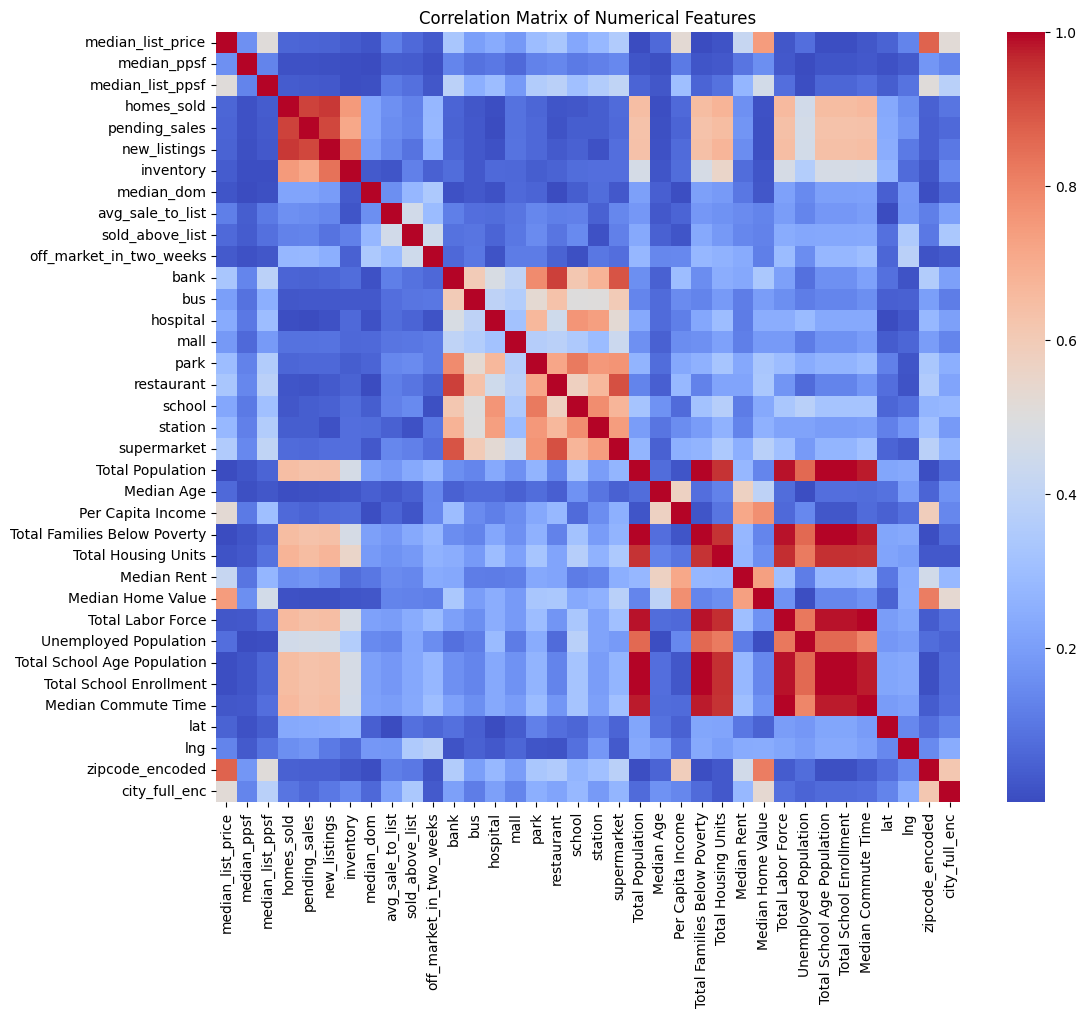

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = train_df.select_dtypes(include=['float64', 'int64']).drop(columns=["price"], errors="ignore")
corr_matrix = numeric_df.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, fmt=".2f", cmap='coolwarm', annot=False)
plt.title("Correlation Matrix of Numerical Features")
plt.show()



In [39]:
# Compute correlation with target variable
target_corr = train_df.corr()['price'].abs().sort_values(ascending=False)
print("Correlation of features with target variable 'price':")
print(target_corr)


Correlation of features with target variable 'price':
price                           1.000000
zipcode_encoded                 0.972310
median_list_price               0.885033
Median Home Value               0.821185
city_full_enc                   0.596488
Per Capita Income               0.589496
median_list_ppsf                0.519078
Median Rent                     0.473753
supermarket                     0.414499
bank                            0.391402
restaurant                      0.389463
park                            0.338821
station                         0.302907
school                          0.251034
hospital                        0.242632
bus                             0.231250
mall                            0.216130
median_ppsf                     0.181333
year                            0.156010
lng                             0.143961
avg_sale_to_list                0.125389
sold_above_list                 0.112706
Unemployed Population           0.096667
lat

In [40]:
"""
high_vif_features = [
    "median_list_price",
    "zipcode_encoded" 
]
train_df.drop(columns=high_vif_features, inplace=True)
validation_df.drop(columns=high_vif_features, inplace=True)
test_df.drop(columns=high_vif_features, inplace=True)

"""

'\nhigh_vif_features = [\n    "median_list_price",\n    "zipcode_encoded" \n]\ntrain_df.drop(columns=high_vif_features, inplace=True)\nvalidation_df.drop(columns=high_vif_features, inplace=True)\ntest_df.drop(columns=high_vif_features, inplace=True)\n\n'

In [41]:
# Save the engineered datasets
train_df.to_csv('../data/processed/HouseTS_train_FE.csv', index=False)
validation_df.to_csv('../data/processed/HouseTS_validation_FE.csv', index=False)
test_df.to_csv('../data/processed/HouseTS_test_FE.csv', index=False)